In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/kvasir_dataset.zip .

In [3]:
!unzip -qq kvasir_dataset.zip

In [4]:
imagePaths = "kvasir_dataset/train/"
test_path = "kvasir_dataset/test/"

In [5]:
batch_size=32
img_height = 224
img_width = 224

In [6]:
import tensorflow as tf

In [7]:
!rm -rf kvasir_dataset/train/.ipynb_checkpoints

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths,
  #color_mode='grayscale',
  validation_split=0.15,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  #label_mode="categorical",
  batch_size=batch_size)

Found 15300 files belonging to 6 classes.
Using 13005 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths, 
  #color_mode='grayscale',
  validation_split=0.15,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  #label_mode="categorical",
  batch_size=batch_size)

Found 15300 files belonging to 6 classes.
Using 2295 files for validation.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_path,
  seed=123,
  image_size=(img_height, img_width),
  #label_mode="categorical",
  batch_size=batch_size)

Found 2700 files belonging to 6 classes.


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
import numpy as np
import os
import datetime
%matplotlib inline

tf.keras.utils.set_random_seed(1234)

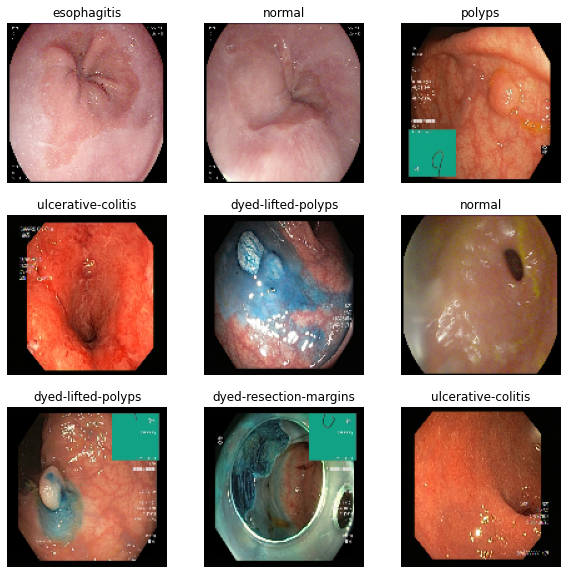

In [ ]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
data_augmentation= Sequential([
                               layers.RandomBrightness(factor=0.2, value_range=(0, 255), seed=123)
])

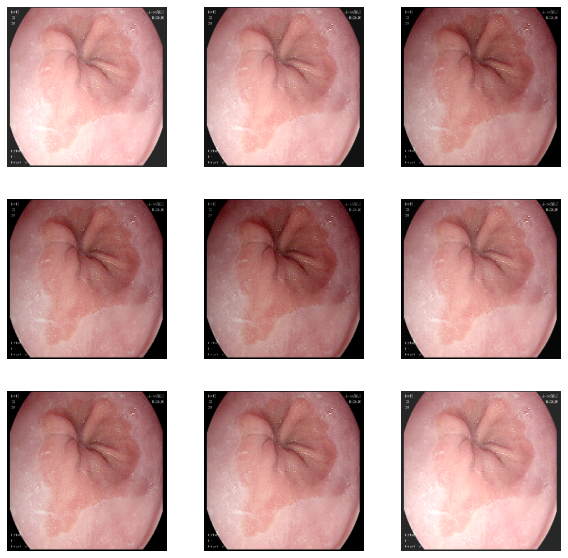

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [15]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [16]:
resnet_base= tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3),
)

94765736/94765736 [==============================] - 1s 0us/step


In [17]:
x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(6, activation='softmax')(x)
model = Model(inputs=resnet_base.input, 
              outputs=x)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [19]:
def get_early_stopping():
    return tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
def get_checkpoint_best_only():
    
    checkpoint_best_path= 'checkpoints_best_only'
    checkpoint_best= ModelCheckpoint(filepath=checkpoint_best_path,
                           frequency='epoch',
                           save_weights_only=False,
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)
    return checkpoint_best
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                  patience=6, min_lr=0.000001)

callbacks = [early_stopping, checkpoint_best_only, tensorboard_callback, reduce_lr]

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"],)

In [22]:
history = model.fit(train_ds, validation_data=val_ds, 
                    batch_size=batch_size, epochs=50, callbacks=callbacks)

Epoch 1/50
407/407 [==============================] - ETA: 0s - loss: 0.8641 - accuracy: 0.6891
Epoch 1: val_accuracy improved from -inf to 0.68017, saving model to checkpoints_best_only


407/407 [==============================] - 343s 737ms/step - loss: 0.8641 - accuracy: 0.6891 - val_loss: 3.4910 - val_accuracy: 0.6802 - lr: 0.0010
Epoch 2/50
407/407 [==============================] - ETA: 0s - loss: 0.4096 - accuracy: 0.8486
Epoch 2: val_accuracy improved from 0.68017 to 0.83355, saving model to checkpoints_best_only


407/407 [==============================] - 298s 725ms/step - loss: 0.4096 - accuracy: 0.8486 - val_loss: 0.4357 - val_accuracy: 0.8336 - lr: 0.0010
Epoch 3/50
407/407 [==============================] - ETA: 0s - loss: 0.3203 - accuracy: 0.8845
Epoch 3: val_accuracy did not improve from 0.83355
407/407 [==============================] - 271s 656ms/step - loss: 0.3203 - accuracy: 0.8845 - val_loss: 0.7093 - val_accuracy: 0.8157 - lr: 0.0010
Epoch 4/50
407/407 [==============================] - ETA: 0s - loss: 0.2748 - accuracy: 0.8981
Epoch 4: val_accuracy did not improve from 0.83355
407/407 [==============================] - 268s 651ms/step - loss: 0.2748 - accuracy: 0.8981 - val_loss: 0.5474 - val_accuracy: 0.7948 - lr: 0.0010
Epoch 5/50
407/407 [==============================] - ETA: 0s - loss: 0.2309 - accuracy: 0.9147
Epoch 5: val_accuracy improved from 0.83355 to 0.84314, saving model to checkpoints_best_only


407/407 [==============================] - 291s 707ms/step - loss: 0.2309 - accuracy: 0.9147 - val_loss: 0.4639 - val_accuracy: 0.8431 - lr: 0.0010
Epoch 6/50
407/407 [==============================] - ETA: 0s - loss: 0.1990 - accuracy: 0.9256
Epoch 6: val_accuracy improved from 0.84314 to 0.89412, saving model to checkpoints_best_only


407/407 [==============================] - 294s 711ms/step - loss: 0.1990 - accuracy: 0.9256 - val_loss: 0.3114 - val_accuracy: 0.8941 - lr: 0.0010
Epoch 7/50
407/407 [==============================] - ETA: 0s - loss: 0.1891 - accuracy: 0.9318
Epoch 7: val_accuracy did not improve from 0.89412
407/407 [==============================] - 278s 675ms/step - loss: 0.1891 - accuracy: 0.9318 - val_loss: 0.3268 - val_accuracy: 0.8863 - lr: 0.0010
Epoch 8/50
407/407 [==============================] - ETA: 0s - loss: 0.1571 - accuracy: 0.9419
Epoch 8: val_accuracy improved from 0.89412 to 0.89804, saving model to checkpoints_best_only

Epoch 8: val_accuracy improved from 0.89412 to 0.89804, saving model to checkpoints_best_only

Epoch 8: val_accuracy improved from 0.89412 to 0.89804, saving model to checkpoints_best_only


407/407 [==============================] - 295s 715ms/step - loss: 0.1571 - accuracy: 0.9419 - val_loss: 0.3118 - val_accuracy: 0.8980 - lr: 0.0010
Epoch 9/50
Epoch 9/50
Epoch 9/50
407/407 [==============================] - ETA: 0s - loss: 0.1290 - accuracy: 0.9515
Epoch 9: val_accuracy did not improve from 0.89804

Epoch 9: val_accuracy did not improve from 0.89804

Epoch 9: val_accuracy did not improve from 0.89804
407/407 [==============================] - 277s 669ms/step - loss: 0.1290 - accuracy: 0.9515 - val_loss: 1.0613 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 10/50
Epoch 10/50
Epoch 10/50
407/407 [==============================] - ETA: 0s - loss: 0.1259 - accuracy: 0.9562
Epoch 10: val_accuracy did not improve from 0.89804

Epoch 10: val_accuracy did not improve from 0.89804

Epoch 10: val_accuracy did not improve from 0.89804
407/407 [==============================] - 275s 668ms/step - loss: 0.1259 - accuracy: 0.9562 - val_loss: 0.3426 - val_accuracy: 0.8976 - lr: 0.0010
Epoc

In [23]:
model.load_weights('./checkpoints_best_only')

In [24]:
model.save("kvasir_resnet.h5")

In [10]:
!cp /content/drive/MyDrive/kvasir_resnet.h5 .

In [12]:
from keras.models import load_model
model = load_model("kvasir_resnet.h5")

In [25]:
from IPython.display import Image, display
     

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [26]:
img_path = tf.keras.utils.get_file(
    "pol22.png", 
    "https://www.endoscopy-campus.com/wp-content/uploads/2016/07/Abb_2c.jpg"
)

70490/70490 [==============================] - 0s 1us/step


1/1 [==============================] - 0s 43ms/step
Predicted: [ -6.913423   -9.954333  -15.916447   -7.4118347 -17.53022   -24.077133 ]


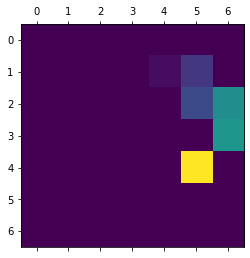

In [30]:
def get_img_array(img_path, target_size):
  img = keras.utils.load_img(img_path, target_size=target_size)
  array = keras.utils.img_to_array(img)
  array = np.expand_dims(array, axis=0)
  return array
img_array = get_img_array(img_path, target_size=(224, 224))
     

# Make model

last_conv_layer_name = "conv5_block3_out"
# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", preds[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [31]:
from IPython.display import Image, display
     

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matcm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))
     

In [33]:
import matplotlib.cm as matcm

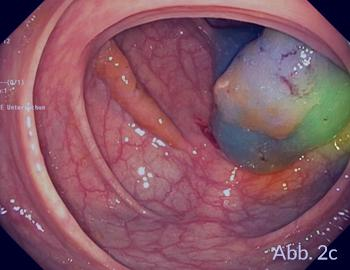

In [34]:
save_and_display_gradcam(img_path, heatmap)

In [13]:
model.evaluate(test_ds)

85/85 [==============================] - 53s 429ms/step - loss: 0.3569 - accuracy: 0.8948


[0.35692059993743896, 0.8948147892951965]

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
     

predictions = np.array([])
labels =  np.array([])
cnt=1
for x, y in test_ds:
  Y_pred=model.predict(x)
  y_prediction = np.argmax(Y_pred, axis=1)
  predictions = np.concatenate([predictions, y_prediction])
  labels = np.concatenate([labels, y.numpy()])
     

print('Confusion Matrix')
print(confusion_matrix(y_true=labels, y_pred=predictions))

1/1 [==============================] - 1s 851ms/step
Confusion Matrix
[[376  74   0   0   0   0]
 [ 16 434   0   0   0   0]
 [  0   0 380  70   0   0]
 [  0   0  20 422   4   4]
 [  3   0   6  17 387  37]
 [  1   0   4  10  18 417]]


In [15]:
classes=['dyed-lifted-polyps','dyed-resection-margins', 'esophagitis','normal','polyps', 'ulcerative-colitis']
  
print('Classification Report')
target_names = classes
print(classification_report(y_true=labels, y_pred=predictions, target_names=target_names))

Classification Report
                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.95      0.84      0.89       450
dyed-resection-margins       0.85      0.96      0.91       450
           esophagitis       0.93      0.84      0.88       450
                normal       0.81      0.94      0.87       450
                polyps       0.95      0.86      0.90       450
    ulcerative-colitis       0.91      0.93      0.92       450

              accuracy                           0.89      2700
             macro avg       0.90      0.89      0.89      2700
          weighted avg       0.90      0.89      0.89      2700



[[376  74   0   0   0   0]
 [ 16 434   0   0   0   0]
 [  0   0 380  70   0   0]
 [  0   0  20 422   4   4]
 [  3   0   6  17 387  37]
 [  1   0   4  10  18 417]]


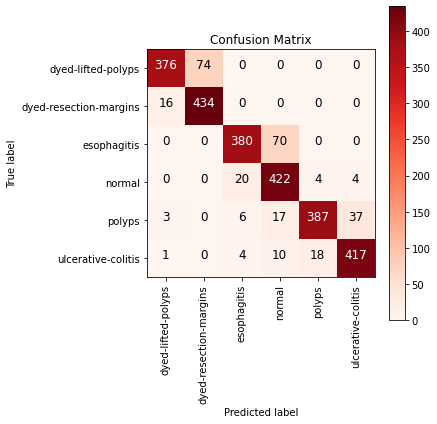

In [16]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Reds):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
#get confusion matrix
cm = confusion_matrix(labels, predictions)
print(cm)

#plot
plot_confusion_matrix(cm, classes, normalize=False)